In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import models
import DataGenerator

In [2]:
data_path = './output/full(0716).json'
mapping_path = './output/mapping(0716).pickle'

full = pd.read_json(data_path)
songmeta =pd.read_json( './data/song_meta.json')

with open(mapping_path, 'rb') as f:
    mapping = pickle.load(f)
    
mapping['inverse_mapping'] = dict(zip(mapping['mapping'].values(), mapping['mapping'].keys()))
dim = mapping['num_songs'] + mapping['num_tags'] + mapping['num_genres']

In [3]:
batch_size = 1

train_gen = DataGenerator.DataGenerator(df = full.loc[full['dataset'] == 0],
                                        mode='predict',
                                        shuffle=False,
                                        batch_size = batch_size)
    
val_gen = DataGenerator.DataGenerator(df = full.loc[full['dataset'] == 1],
                                      shuffle=False,
                                      mode='predict',
                                      batch_size = batch_size)

In [5]:
autoencoder = models.AutoEncoder(dim_input=dim, dim_latent=256)
autoencoder.build((batch_size, dim))

autoencoder.load_weights('./model_checkpoints/tied_dae_loss055')

autoencoder.set_weights([autoencoder.weights[0].numpy(),
                         autoencoder.weights[1].numpy(),
                         autoencoder.weights[0].numpy().T,
                         autoencoder.weights[3].numpy()])

In [4]:
def predict_batches(model, batches):
    latent = model.encoder(batches)
    output = model.decoder(latent)
    
    return output

def predict_batches_TOPK(model, batches, lookup, K=10):
    output = predict_batches(model, batches)
    
    songs_pred = output[:, :123464]
    tags_pred = output[:, 123464:123464+25499]
    genres_pred = output[:, 123464+25499:]
    
    sorted_songs_pred = np.flip(np.argsort(songs_pred))[:,:K]
    sorted_tags_pred = np.flip(np.argsort(tags_pred))[:,:K] + 123464
    sorted_genres_pred = np.flip(np.argsort(genres_pred))[:,:K] + 123464+25499
    
    songs_pred = []
    for row in sorted_songs_pred:
        songs_pred.append([songmeta.loc[lookup[song],'song_name'] for song in row])
        
    tags_pred = []
    for row in sorted_tags_pred:
        tags_pred.append([lookup[tag] for tag in row])
        
    genres_pred = []
    for row in sorted_genres_pred:
        genres_pred.append([lookup[genre] for genre in row])
    
    
    return np.concatenate((songs_pred, tags_pred, genres_pred), axis = 1)

In [27]:
a = val_gen.__iter__()
b = train_gen.__iter__()

In [28]:
batches = next(a)

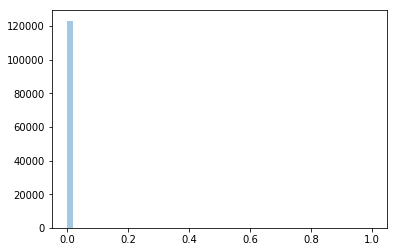

In [19]:
sns.distplot((autoencoder.predict(batches)[0][:123464]),kde=False)

In [18]:
(autoencoder.predict(batches)[0] == 1.0).sum()

3

In [21]:
(autoencoder.predict(batches)[0][:123464]).max()

0.99912196

In [17]:
(autoencoder.predict(batches)[0][123464:123464+25499] == 1.0).sum()

0

In [29]:
predict_batches_TOPK(autoencoder, batches, mapping['inverse_mapping'], K=50)

array([['守ってあげたい / Mamotte Agetai (지켜주고 싶어)',
        '道化師のソネット / Doukeshino Sonnet (피에로의 소네트)', 'Show Me', 'Moai',
        'Walk', '설마 그럴 리가 없어', 'Audition (Time2Rock)', '환상',
        'にんじん / Ninjin (당근)', 'Never Been Gone', '고백', '바보에게... 바보가',
        'ブ-アの森 /Boer No Mori (보어(Boer)의 숲)', 'Wings', '좀 더 둘이서',
        '함께 있는 우리를 보고 싶다', '연애의 방식', 'Hoshi Uta (별의 노래)', '한사람을 위한 마음',
        '그런 사람 또 없습니다', 'Movin` On', 'Rat', '소격동', 'Picnic',
        'Jingle Bells', '청춘 (Feat. 이상순)', 'Air On G String (G선상의 아리아)',
        'Just Go', 'Baby Blue', 'Mr.Miz (Feat. DEPAPEPE, Miz)', '1/10',
        'Let Us Go To The Wood', '봄눈', '살랑살랑', '천개의 바람이 되어',
        '잊지 말기로 해 (Bonus Track)', '다 줄거야 (Acoustic Ver.)',
        'チャッタリング / Chattering', 'The Broken', 'New Home', 'Fly Away',
        'Please Don`t Go', 'I`m Not In Love',
        'Pai De Santo (Feat. Woz Kaly)', 'Last Song', '아침의 눈', '그게 나야',
        '욕심쟁이 (duet with 이소은)', 'Asitakato San (아시타카와 산) (`원령공주` 중에서)',
        '절대사랑', '겨울', '기다림', '락

In [26]:
predict_batches_TOPK(autoencoder, next(a), mapping['inverse_mapping'], K=50)

array([['듣고 자요', '별 보러 가자', '일기', '별', '혼잣말', '너의 밤은 어때', '잘거예요?', '달산책',
        'HELP', '밤에 잠이 안 올 때', '밤하늘의 별들은', '자취방에서', 'Little Star',
        '별이 되지 않아도 돼', '나 좋다는 사람', '흐르는 시간 속에 우리는 아름다워', '오늘', '백야',
        '위로 (Feat. 준모 (프로젝트 슈즈))', '겨울을 걷는다', '니가 보고싶은 밤', '새벽', '자장가',
        '내가 니편이 되어줄게 (Feat. 하은)', '소란했던 시절에', '에펠탑 효과', '그믐달', '너의 하루',
        '누군가의 빛나던', '하늘엔 별이 떠있고 너만큼은 빛나질 않아',
        '누군가의 위로가 필요한 밤 (Remastered)', '고래에게', '수고했어, 오늘도',
        'Call Me Now', '쉿', '27살의 고백', '너라는 여행', '퇴근길', '새벽 통화',
        '어른이 된다는 건', 'The Door', '처음이니까', '비', '나는 새롭게 떠오른 외로움을 봐요',
        '좋았을텐데', '답답한 새벽', '잡지 않았어', '너를 수놓은 밤 (feat. 멜튼 Of 굿나잇스탠드)',
        '너와 나의 별이야기 (Piano 양자인)', '노력', '새벽', '밤', '감성', '인디', '잔잔한',
        '인디음악', '발라드', '기분전환', '위로', '어쿠스틱', '사랑', '혼자', '겨울', '여름',
        '힐링', '자기전에_듣기좋은_노래', '잠들기전', '잔잔', '음악', '가을', '자기전', '팝',
        '감성인디', '인디추천', '휴식', '비오는날', '늦은밤', '지친', '퇴근길', '쓸쓸함', '잘자요',
        '가을밤', '음악추천', '하루', '인디감성', '가요', '스트레스', '새벽감성'

In [30]:
genres = pd.read_json("./data/genre_gn_all.json", typ='series')

In [45]:
full[full['dataset']==1]

,tags,id,plylst_title,songs,like_cnt,updt_date,dataset,genres
1,[],10532,요즘 너 말야,"[109538, 1286, 107, 24687, 85301, 115461, 7698...",1,2014-12-02 16:19:42.000,1,"[149038, 149006, 149066, 149029, 148963, 14897..."
4,[],27616,추억의 노래 ㅋ,"[31734, 4180, 1146, 693, 6486, 796, 2109, 8254...",9,2011-10-25 13:54:56.000,1,"[148978, 148980, 148992, 148973, 149035, 14898..."
6,"[123489, 123478, 123471]",45339,짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!,"[1767, 656, 6643, 3165, 2651, 1409, 1013, 1459...",24,2016-10-24 21:30:17.000,1,"[148984, 148964, 148969, 148963, 148974, 14896..."
8,"[123528, 123610, 123624]",70741,DANCING IN THE MOON-LIGHT .01,"[90815, 3602, 1171, 1572, 17735, 119423, 10487...",0,2019-11-30 21:17:59.000,1,"[148966, 148975, 148969, 148963, 148964, 14897..."
10,"[125516, 123715]",31804,걸그룹 땐쓰쏭,"[2151, 1444, 132, 108, 1135, 970, 3991, 13816,...",74,2020-04-13 23:36:55.000,1,"[148985, 148994, 148973, 148992, 148978, 14897..."
...,...,...,...,...,...,...,...,...
115058,[],79538,여자친구 명곡,"[44040, 7787, 9471, 6385, 11559, 23204, 9375, ...",6,2018-03-09 14:24:37.000,1,"[149017, 148994, 148963, 148978, 148985, 14897..."
115060,"[123594, 123625, 123772, 123469, 123528]",63967,#기분업! 에너지필~ 사운드굿! 해외 EDM/일렉 선곡#2019년9월#,"[58044, 7580, 111384, 66910, 100591, 15316, 11...",10,2019-12-21 11:22:39.000,1,"[149048, 149061, 149046, 149011, 149027, 14899..."
115061,[],53627,카페에서 손님들이 궁금해하는노래^.^,"[4547, 1227, 1827, 534, 22411, 4, 466, 2554, 2...",489,2013-10-08 18:05:58.000,1,"[148969, 148964, 148966, 148975, 148963, 14898..."
115062,[123470],2531,J pop처음 듣는 사람도 중독된 듯 빠져드는 j pop 리스트,"[11354, 77817, 51023, 82026, 121135, 122271, 8...",344,2015-12-30 19:41:08.000,1,"[149018, 149039, 149016, 149069, 149076, 14906..."


In [52]:
songmeta[songmeta['id']==mapping['inverse_mapping'][85301]]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
129258,"[GN1803, GN1801]",20140610,LUNCH de PIANO Part2,2259920,[774540],道化師のソネット / Doukeshino Sonnet (피에로의 소네트),[GN1800],[Obara Takashi],129258
